2024-12-04 17:52:29.114790: W external/xla/xla/service/platform_util.cc:206] unable to create StreamExecutor for CUDA:0: CUDA error: : CUDA_ERROR_DEVICE_UNAVAILABLE: CUDA-capable device(s) is/are busy or unavailable
2024-12-04 17:52:29.259568: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.6.77. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


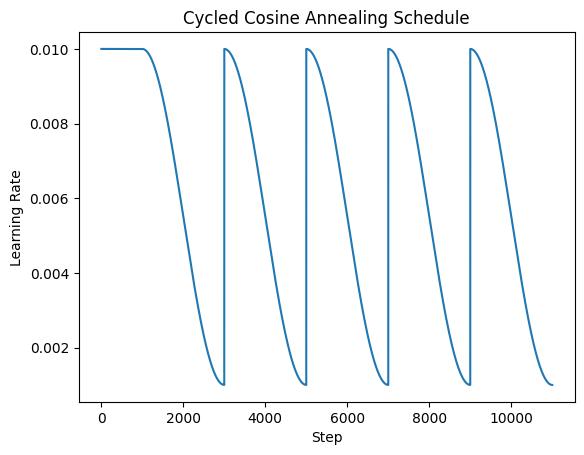

In [1]:
import jax.numpy as jnp
import optax

def cycled_cosine_annealing_schedule(init_lr, min_lr, cycle_length, num_cycles, start_step=0):
    """
    Creates a cosine annealing learning rate schedule with repeated cycles.

    Args:
        init_lr (float): Initial learning rate at the start of each cycle.
        min_lr (float): Minimum learning rate after annealing within a cycle.
        cycle_length (int): Number of steps per cycle.
        num_cycles (int): Total number of cycles.
        start_step (int): Step at which the schedule starts (default is 0).

    Returns:
        optax.Schedule: A cycled cosine annealing learning rate schedule.
    """

    def schedule_fn(step):
        # Adjust step to account for the starting step
        adjusted_step = step - start_step
        if adjusted_step < 0:
            return init_lr  # Return the initial learning rate until start_step is reached
        
        # Determine the current cycle
        cycle_idx = adjusted_step // cycle_length
        if cycle_idx >= num_cycles:
            return min_lr  # Return min_lr after all cycles are complete
        
        # Calculate progress within the current cycle
        cycle_progress = (adjusted_step % cycle_length) / cycle_length
        cosine_decay = 0.5 * (1 + jnp.cos(jnp.pi * cycle_progress))
        lr = min_lr + (init_lr - min_lr) * cosine_decay
        return lr

    return schedule_fn

# Example usage:
init_lr = 0.01
min_lr = 0.001
cycle_length = 2000  # Steps per cycle
num_cycles = 5
start_step = 1000  # Start annealing after step 1000

cosine_schedule = cycled_cosine_annealing_schedule(init_lr, min_lr, cycle_length, num_cycles, start_step)
optimizer = optax.chain(
    optax.scale_by_adam(),  # Adam optimizer
    optax.scale_by_schedule(cosine_schedule),  # Cycled cosine annealing schedule
    optax.scale(-1.0),  # Apply negative scaling for gradient descent
)

# Example of applying the schedule
import matplotlib.pyplot as plt

# Plot learning rate over training steps
total_steps = start_step + num_cycles * cycle_length
steps = list(range(total_steps))
lrs = [cosine_schedule(step) for step in steps]

plt.plot(steps, lrs)
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Cycled Cosine Annealing Schedule")
plt.show()

In [93]:
import jax.numpy as jnp
import optax

def cycled_cosine_annealing_schedule(
    init_lr, period=100):
    """
    Creates a cosine annealing learning rate schedule with repeated cycles.

    Args:
        init_lr (float): Initial learning rate at the start of each cycle.
        period (int): The number of steps in each cycle.
    Returns:
        optax.Schedule: A cycled cosine annealing learning rate schedule.
    """

    # Adjust step to account for the starting step
    num_cycles = 10
    print(period,num_cycles)
    lr_schedule = optax.join_schedules(
        schedules=
        [
            optax.cosine_onecycle_schedule(
                            transition_steps=period//2,
            peak_value=init_lr*(0.9**i),
            div_factor=1.5,
            final_div_factor=2
            )
            for i in range(num_cycles)
        ],
    boundaries=jnp.cumsum(jnp.array([period] * num_cycles))
    )

    return lr_schedule

In [101]:
s = cycled_cosine_annealing_schedule(0.01)
s(100),s(110),s(200)

100 10


(Array(0.006, dtype=float32),
 Array(0.00825, dtype=float32),
 Array(0.0054, dtype=float32))

In [98]:
xvalues = jnp.arange(1,10**3,10*2)
yvalues = [s(_) for _ in xvalues]

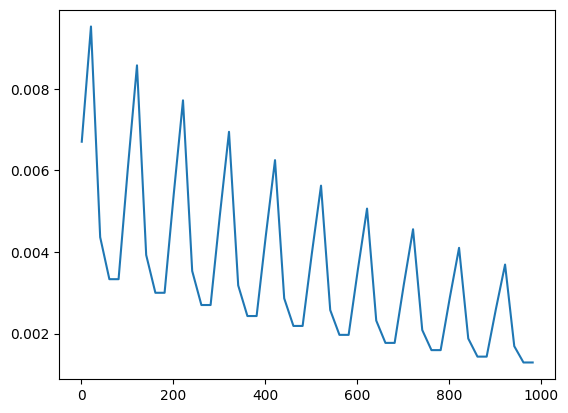

In [99]:
import matplotlib.pyplot as plt

plt.plot(xvalues, yvalues)

In [72]:
help(optax.cosine_onecycle_schedule)

Help on function cosine_onecycle_schedule in module optax.schedules._schedule:

cosine_onecycle_schedule(transition_steps: int, peak_value: float, pct_start: float = 0.3, div_factor: float = 25.0, final_div_factor: float = 10000.0) -> Callable[[Union[jax.Array, numpy.ndarray, numpy.bool_, numpy.number, float, int]], Union[jax.Array, numpy.ndarray, numpy.bool_, numpy.number, float, int]]
    Returns a function which implements the onecycle learning rate schedule.

    This learning rate increases the learning rate and then decreases it in a
    cosine-like manner. The number of steps over which the learning rate increases
    is determined by the ``pct_start`` argument. The maximum value of the learning
    rate is determined by the ``peak_value`` argument, the initial value of the
    learning rate is determined through the formula ``init_value = peak_value /
    div_factor``, and the final value is determined by the ``final_div_factor``
    argument.

    References:
      Smith et al